# Quality Control Workflow for Quotes

In this notebook, we demonstrate how users can create a workflow to upload quote data into LUSID. The workflow will then conduct a series of data quality checks on these quotes, raising any issues as exceptions for approval. This will help us to ensure the data we are upserting to LUSID is valid and suitable.

## Overview

We will be making use of the the Workflow Service which enables you to connect and control movement of data throughout LUSID, allowing you to model data and business operational controls. You can read more about the Workflow Service in the [Knowledge Base](https://support.lusid.com/knowledgebase/article/KA-02181/en-us).



For the purposes of this notebook, we will consider an example where an Excel file has been uploaded to LUSID Drive. This file contains quotes for various instruments. Our workflow will then work as follows:
1. The `ImportQuotes` task will be created and started.
2. A worker will be triggered to import quote data, from the given file in Drive, into LUSID.
3. A child task `ReasonableValueDataControl` will be created and started.
  - This will trigger a worker flag values that are not between 1 and 1000.
4. A child task `IQROutlierDataControl` will be created and started.
  - This will trigger a worker flag values that are not within the interquartile range of existing quotes for that instrument.
4. TODO: deviations from the mean (e.g. 2.5SD)?, percentage checks from last quote?*
5. A child task `HandleException` will be created for each flagged value so a user can review any failures.

An overview of our workflow is below.

*TODO: Ammend this diagram. It's not entirely representive of what we have created.*

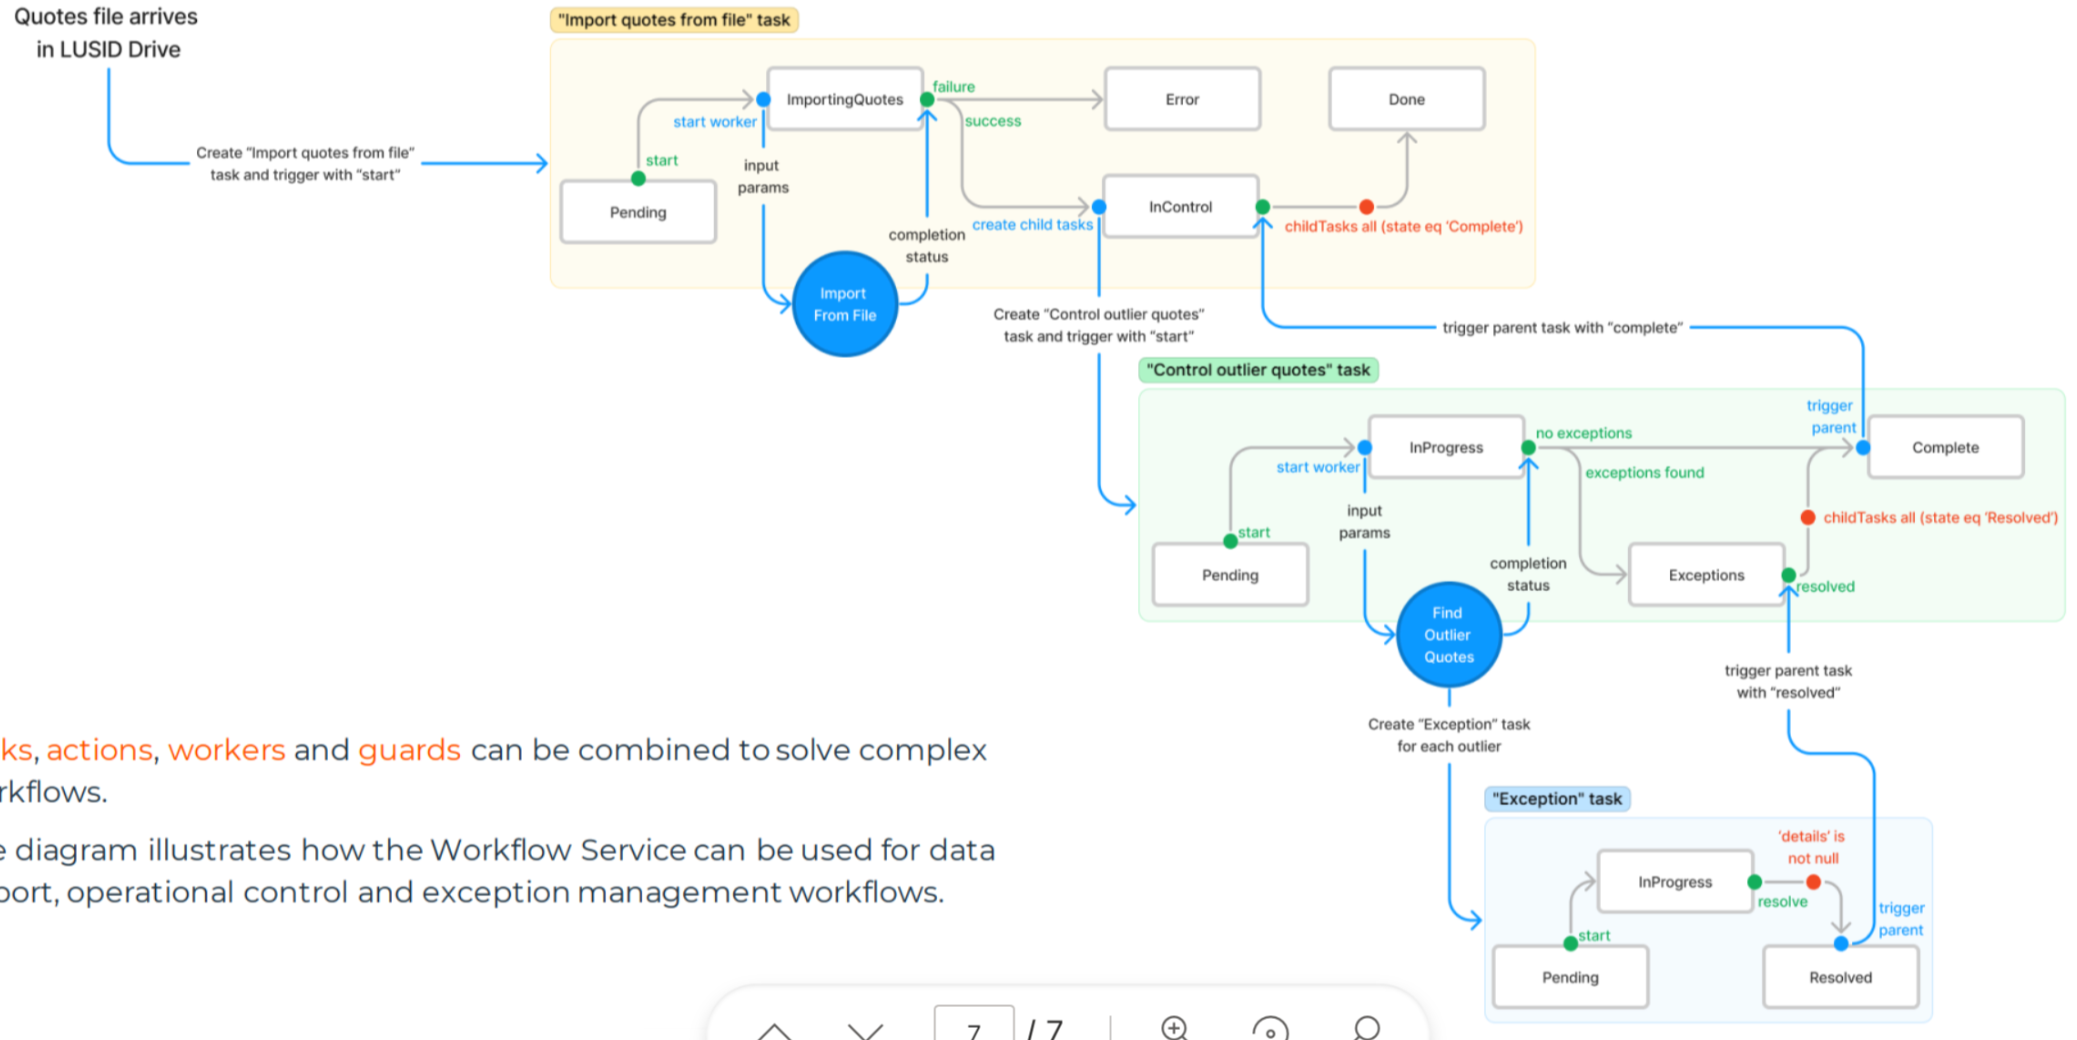

## Setup LUSID

We start by importing relevant libraries, authenticating our user, and creaing our API client.

In [1]:
# TODO: Remove line
!pip install -U lusid-workflow-sdk-preview

# Import general purpose packages
import sys
import time

# Import LUSID specific packages
from fbnsdkutilities import ApiClientFactory
import lusid_workflow
import lusid_workflow.models as wf_models
from lusid_workflow.rest import ApiException
from lusidjam.refreshing_token import RefreshingToken
from lusidtools.pandas_utils.lusid_pandas import lusid_response_to_data_frame

# Authenticate out user and create our API client
# TODO: Have this work with fbnsdkutilities instead
configuration = lusid_workflow.Configuration(
    host="https://matthewfox.lusid.com/workflow"
)
configuration.access_token = RefreshingToken()

api_client = lusid_workflow.ApiClient(configuration)

In [ ]:
# Define the relevant APIs we will use
task_def_api = lusid_workflow.TaskDefinitionsApi(api_client)
task_api = lusid_workflow.TasksApi(api_client)
worker_api = lusid_workflow.WorkersApi(api_client)

# Notebook constants
notebook_scope = 'quotes-workflow'

## 1. Prepare Luminesce Views & Workers

In our workflow, we will be making use of workers. A worker makes use if Luminesce Views to input parameters mapped from the fields of a task, and return results which can be mapped to a task definition.

### 1.1. Import Quotes from File

Our first worker will take a filename of an Excel file in Drive, as a parameter, and load quote and instrument data into LUSID. 

In [35]:
%%luminesce


-- Create view and set parameters
@import_quotes_view = use Sys.Admin.SetupView
    --provider=Custom.Quotes.ImportFromCSV
    --parameters
        filename,Text,/quotes/exampledata.xlsx,false
----

@@filename = select #PARAMETERVALUE(filename);


-- Load data from csv
@inst_data = use Drive.Excel with @@filename
    --file={@@filename}
    --worksheet=instrument
enduse;

@quote_data = use Drive.Excel with @@filename
    --file={@@filename}
    --worksheet=price_time_series
enduse;


-- Create instruments if not Active
@equity_instruments =
    select inst_id as ClientInternal, name as DisplayName, ccy as DomCcy
    from @inst_data;

select *
from Lusid.Instrument.Equity.Writer
where ToWrite = @equity_instruments;


-- Transform quote data
@quotes_for_upload =
    select
        'ClientInternal' as InstrumentIdType,
        instrument_id as InstrumentId,
        'quotes-workflow' as QuoteScope,
        'Price' as QuoteType,
        'Lusid' as Provider,
        'Mid' as Field,
        price_date as QuoteEffectiveAt,
        price as Value,
        ccy as Unit
    from @quote_data;


-- Upload quotes into LUSID
select *
from Lusid.Instrument.Quote.Writer
where ToWrite = @quotes_for_upload;

enduse;

select * from Custom.Quotes.ImportFromCSV
where filename='/quotes/exampledata.xlsx';

,WriteAsAt,WriteErrorCode,WriteError,WriteErrorDetail,WriteAction,LusidInstrumentId,Isin,Sedol,Cusip,Ticker,...,State,AsAtCreated,UserIdCreated,RequestIdCreated,AsAtModified,UserIdModified,RequestIdModified,AsAtVersionNumber,Identifiers,DomCcy
0,2023-10-23 13:56:00.443,0,NaN,NaN,Upsert,LUID_00003DCU,NaN,NaN,NaN,NaN,...,Active,2023-10-23 13:56:00.443,00uh5cp6tdahVrHMY2p7,e919601c-01ca-4f51-8d8f-e9be25b344ff,2023-10-23 14:05:52.280,00uh5cp6tdahVrHMY2p7,5193fa49-d81e-4965-94a0-6d6f0beef7d1,4,NaN,USD
1,2023-10-23 13:56:00.443,0,NaN,NaN,Upsert,LUID_00003DCT,NaN,NaN,NaN,NaN,...,Active,2023-10-23 13:56:00.443,00uh5cp6tdahVrHMY2p7,e919601c-01ca-4f51-8d8f-e9be25b344ff,2023-10-23 14:05:52.280,00uh5cp6tdahVrHMY2p7,5193fa49-d81e-4965-94a0-6d6f0beef7d1,4,NaN,GBP
2,2023-10-23 14:05:52.105,0,NaN,NaN,Upsert,LUID_00003DCW,NaN,NaN,NaN,NaN,...,Active,2023-10-23 14:05:52.105,00uh5cp6tdahVrHMY2p7,5193fa49-d81e-4965-94a0-6d6f0beef7d1,2023-10-23 14:05:52.105,00uh5cp6tdahVrHMY2p7,5193fa49-d81e-4965-94a0-6d6f0beef7d1,1,NaN,USD


In [ ]:
import_from_csv_worker_request = wf_models.CreateWorkerRequest(
    id=wf_models.ResourceId(scope=notebook_scope, code="ImportFromCSV"),
    display_name="Import From CSV",
    description="Imports quote data from specified Excel file in Drive.",
    worker_configuration=wf_models.LuminesceView(
        type="LuminesceView", name="Custom.Quotes.ImportFromCSV"
    ),
)

try:
    response = worker_api.create_worker(
        create_worker_request=import_from_csv_worker_request
    )
    print(response)
except ApiException as e:
    if e.status == 409:
        print("Worker already exists.")
    else:
        raise e


### 1.2. DQ check for IQR range

Our next worker will search for any IQR outliers in a given scope, returning any it finds.

In [36]:
%%luminesce


-- Create view and set parameters
@iqr_outlier_view = use Sys.Admin.SetupView
--provider=Custom.PriceCheck.OnePointFiveIQR
----
    
-- Collect quotes for all instruments
@quotes_data = select *
    from Lusid.Instrument.Quote
    where QuoteScope = 'quotes-workflow'
        and InstrumentIdType = 'ClientInternal'
        and QuoteType = 'Price';
        
-- Collect instrument static
@instrument_data = select
    ClientInternal,
    DisplayName
    from Lusid.Instrument.Equity
    where State = 'Active';
    
-- Generate time series
@price_ts = select
    ClientInternal,
    DisplayName,
    QuoteEffectiveAt as [PriceDate],
    Unit as [Currency],
    Value as [Price]
    from @instrument_data i
    join @quotes_data q on (i.ClientInternal = q.InstrumentId);
    
-- Run IQR checks for each instrument
@iqr_data = select
    ClientInternal,
    interquartile_range(price) * (1.5) as [iqr_x1_5],
    quantile(price, 0.25) as [q1],
    quantile(price, 0.75) as [q3]
    from @price_ts
    group by ClientInternal;
    
-- Join the IQR data with the time series and identify outliers
select
    p.PriceDate,
    p.ClientInternal,
    p.DisplayName,
    i.q1,
    i.q3,
    (i.q3 + i.iqr_x1_5) as [UpperLimit],
    (i.q1 - i.iqr_x1_5) as [LowerLimit],
    p.Price,
    case when p.Price not between (i.q1 - i.iqr_x1_5) and (i.q3 + i.iqr_x1_5)
        then 'IQR Outlier'
        else 'OK'
    end as Result
    from @price_ts p
    join @iqr_data i on p.ClientInternal = i.ClientInternal
    where not Result = 'OK';

enduse;

select * from Custom.PriceCheck.OnePointFiveIQR

,PriceDate,ClientInternal,DisplayName,q1,q3,UpperLimit,LowerLimit,Price,Result
0,2022-04-14,EQ56JD720345,Visa Inc,61,89,131.0,19.0,5,IQR Outlier
1,2022-04-21,EQ56JD720345,Visa Inc,61,89,131.0,19.0,1,IQR Outlier
2,2022-05-26,EQ56JD720345,Visa Inc,61,89,131.0,19.0,509,IQR Outlier
3,2022-01-08,EQ56JD720LSU,Tesco Plc,280,362,485.0,157.0,98,IQR Outlier
4,2022-02-20,EQ56JD720LSU,Tesco Plc,280,362,485.0,157.0,900,IQR Outlier
5,2022-02-21,EQ56JD720LSU,Tesco Plc,280,362,485.0,157.0,800,IQR Outlier
6,2022-07-25,EQ56JD720LSU,Tesco Plc,280,362,485.0,157.0,1005,IQR Outlier
7,2022-01-23,EQ56JD720MDJ,Pay Pal Holdings Inc,94,105,121.5,77.5,150,IQR Outlier
8,2022-02-20,EQ56JD720MDJ,Pay Pal Holdings Inc,94,105,121.5,77.5,40,IQR Outlier


In [ ]:
iqr_outliers_worker_request = wf_models.CreateWorkerRequest(
    id=wf_models.ResourceId(scope=notebook_scope, code="IQROutliers"),
    display_name="IQR Outliers",
    description="Find any IQR outlier quotes.",
    worker_configuration=wf_models.LuminesceView(
        type="LuminesceView", name="Custom.PriceCheck.OnePointFiveIQR"
    )
)

try:
    response = worker_api.create_worker(
        create_worker_request=iqr_outliers_worker_request
    )
    print(response)
except ApiException as e:
    if e.status == 409:
        print("Worker already exists.")
    else:
        raise e

### 1.3. DQ check for a reasonable value 

Our next worker, will look for any values that are not between 1 and 1000, returning any it finds.

In [37]:
%%luminesce


-- Create view and set parameters
@iqr_outlier_view = use Sys.Admin.SetupView
--provider=Custom.PriceCheck.ReasonableValue
----
    
-- Collect quotes for all instruments
@quotes_data = select *
    from Lusid.Instrument.Quote
    where QuoteScope = 'quotes-workflow'
        and InstrumentIdType = 'ClientInternal'
        and QuoteType = 'Price';
        
-- Collect instrument static
@instrument_data = select
    ClientInternal,
    DisplayName
    from Lusid.Instrument.Equity
    where State = 'Active';
    
-- Generate time series
@price_ts = select
    ClientInternal,
    DisplayName,
    QuoteEffectiveAt as [PriceDate],
    Unit as [Currency],
    Value as [Price]
    from @instrument_data i
    join @quotes_data q on (i.ClientInternal = q.InstrumentId);
    
-- Run reasonable value check for each quote
select
    PriceDate,
    ClientInternal,
    DisplayName,
    Price,
    case 
        when Price >= 1000 then 'Unreasonably Large Value'
        when Price <= 1 then 'Unreasonably Small Value'
        else 'OK'
    end as Result
    from @price_ts
    where not Result = 'OK';

enduse;

select * from Custom.PriceCheck.ReasonableValue

,PriceDate,ClientInternal,DisplayName,Price,Result
0,2022-04-21,EQ56JD720345,Visa Inc,1,Unreasonably Small Value
1,2022-07-25,EQ56JD720LSU,Tesco Plc,1005,Unreasonably Large Value


In [ ]:
reasonable_value_worker_request = wf_models.CreateWorkerRequest(
    id=wf_models.ResourceId(scope=notebook_scope, code="ReasonableValueChecker"),
    display_name="Reasonable Value Checker",
    description="Find any quotes with values not between 1 and 1000.",
    worker_configuration=wf_models.LuminesceView(
        type="LuminesceView", name="Custom.PriceCheck.ReasonableValue"
    )
)

try:
    response = worker_api.create_worker(
        create_worker_request=reasonable_value_worker_request
    )
    print(response)
except ApiException as e:
    if e.status == 409:
        print("Worker already exists.")
    else:
        raise e

## Task Definitions

1. Handle Exception Task

In [26]:
handle_exception_task_definition_request = wf_models.CreateTaskDefinitionRequest(
    id=wf_models.ResourceId(scope=notebook_scope, code="HandleException"),
    display_name="Handle Exception",
    description="Handle any data outliers that are raised.",
    states=[
        wf_models.TaskStateDefinition(name="Pending"),
        wf_models.TaskStateDefinition(name="InProgress"),
        wf_models.TaskStateDefinition(name="Resolved"),
        wf_models.TaskStateDefinition(name="OnHold"),
        wf_models.TaskStateDefinition(name="Ignored")
    ],
    field_schema=[
        wf_models.TaskFieldDefinition(name="PriceDate", type="DateTime"),
        wf_models.TaskFieldDefinition(name="ClientInternal", type="String"),
        wf_models.TaskFieldDefinition(name="DisplayName", type="String"),
        wf_models.TaskFieldDefinition(name="Price", type="Decimal"),
        wf_models.TaskFieldDefinition(name="Result", type="String"),
        wf_models.TaskFieldDefinition(name="Details", type="String")
    ],
    initial_state=wf_models.InitialState(name="Pending", required_fields=[
        "PriceDate", "ClientInternal", "DisplayName", "Price", "Result"
    ]),
    triggers=[
        wf_models.TransitionTriggerDefinition(name="Start", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="Resolve", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="PlaceOnHold", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="Resume", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="Ignore", trigger=wf_models.TriggerSchema(type="External"))
    ],
    transitions=[
        wf_models.TaskTransitionDefinition(
            from_state="Pending",
            to_state="InProgress",
            trigger="Start"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="InProgress",
            to_state="Resolved",
            trigger="Resolve",
            guard="fields['Details'] neq ''",
            action="resolved-trigger-parent"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="InProgress",
            to_state="OnHold",
            trigger="PlaceOnHold",
        ),
        wf_models.TaskTransitionDefinition(
            from_state="OnHold",
            to_state="InProgress",
            trigger="Resume"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="InProgress",
            to_state="Ignored",
            trigger="Ignore",
            guard="fields['Details'] neq ''",
            action="resolved-trigger-parent"
        )
    ],
    actions=[
        wf_models.ActionDefinition(
            name="resolved-trigger-parent",
            action_details=wf_models.TriggerParentTaskAction(
                type="TriggerParentTask",
                trigger="Resolved"
            )
        )
    ]
)
# print(handle_exception_task_definition_request)

try:
    response = task_def_api.create_task_definition(
        create_task_definition_request=handle_exception_task_definition_request
    )
    print(response)
except ApiException as e:
    if e.status == 409:
        print("Task Definition already exists.")
    else:
        raise e

{'actions': [{'action_details': {'child_task_configurations': None,
                                 'trigger': 'Resolved',
                                 'type': 'TriggerParentTask',
                                 'worker_as_at': None,
                                 'worker_id': None,
                                 'worker_parameters': None,
                                 'worker_status_triggers': None},
              'name': 'resolved-trigger-parent'}],
 'description': 'Handle any data outliers that are raised.',
 'display_name': 'Handle Exception',
 'field_schema': [{'name': 'PriceDate', 'type': 'DateTime'},
                  {'name': 'ClientInternal', 'type': 'String'},
                  {'name': 'DisplayName', 'type': 'String'},
                  {'name': 'Price', 'type': 'Decimal'},
                  {'name': 'Result', 'type': 'String'},
                  {'name': 'Details', 'type': 'String'}],
 'id': {'code': 'HandleException', 'scope': 'quotes-workflow'},
 'initial_st

2. Quotes Data Control Task

In [27]:
reasonable_value_control_task_definition_request = wf_models.CreateTaskDefinitionRequest(
    id=wf_models.ResourceId(scope=notebook_scope, code="ReasonableValueDataControl"),
    display_name="Reasonable Value Data Control",
    description="Conduct reasonable value data control on quote data. Raise any exceptions.",
    states=[
        wf_models.TaskStateDefinition(name="Pending"),
        wf_models.TaskStateDefinition(name="InDQControl"),
        wf_models.TaskStateDefinition(name="Exceptions"),
        wf_models.TaskStateDefinition(name="Complete")
    ],
    initial_state=wf_models.InitialState(name="Pending"),
    triggers=[
        wf_models.TransitionTriggerDefinition(name="Start", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="NoExceptions", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="ExceptionsFound", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="Resolved", trigger=wf_models.TriggerSchema(type="External"))
    ],
    transitions=[
        wf_models.TaskTransitionDefinition(
            from_state="Pending",
            to_state="InDQControl",
            trigger="Start",
            action="start-reasonable-value-worker"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="InDQControl",
            to_state="Complete",
            trigger="NoExceptions",
            action="complete-trigger-parent"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="InDQControl",
            to_state="Exceptions",
            trigger="ExceptionsFound"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="Exceptions",
            to_state="Complete",
            trigger="Resolved",
            guard="childTasks all (state eq 'Resolved' or state eq 'Ignored')",
            action="complete-trigger-parent"
        )
    ],
    actions=[
        wf_models.ActionDefinition(
            name="start-reasonable-value-worker",
            action_details=wf_models.RunWorkerAction(
                type="RunWorker",
                worker_id=wf_models.ResourceId(scope=notebook_scope, code="ReasonableValueChecker"),
                worker_status_triggers=wf_models.WorkerStatusTriggers(
                    completed_with_results="ExceptionsFound",
                    completed_no_results="NoExceptions",
                ),
                child_task_configurations=[wf_models.ResultantChildTaskConfiguration(
                    task_definition_id=wf_models.ResourceId(scope=notebook_scope, code="HandleException"),
                    initial_trigger="Start",
                    child_task_fields={
                        "PriceDate": wf_models.FieldMapping(map_from="PriceDate"),
                        "ClientInternal": wf_models.FieldMapping(map_from="ClientInternal"),
                        "DisplayName": wf_models.FieldMapping(map_from="DisplayName"),
                        "Price": wf_models.FieldMapping(map_from="Price"),
                        "Result": wf_models.FieldMapping(map_from="Result"),
                    }
                )]
            )
        ),
        wf_models.ActionDefinition(
            name="complete-trigger-parent",
            action_details=wf_models.TriggerParentTaskAction(
                type="TriggerParentTask",
                trigger="Complete"
            )
        )
    ]
)
try:
    response = task_def_api.create_task_definition(
        create_task_definition_request=reasonable_value_control_task_definition_request
    )
    print(response)
except ApiException as e:
    if e.status == 409:
        print("Task Definition already exists.")
    else:
        raise e

{'actions': [{'action_details': {'child_task_configurations': [{'child_task_fields': {'ClientInternal': {'map_from': 'ClientInternal',
                                                                                                         'set_to': None},
                                                                                      'DisplayName': {'map_from': 'DisplayName',
                                                                                                      'set_to': None},
                                                                                      'Price': {'map_from': 'Price',
                                                                                                'set_to': None},
                                                                                      'PriceDate': {'map_from': 'PriceDate',
                                                                                                    'set_to': None},
                       

In [32]:
iqr_outlier_control_task_definition_request = wf_models.CreateTaskDefinitionRequest(
    id=wf_models.ResourceId(scope=notebook_scope, code="IQROutlierDataControl"),
    display_name="IQR Outlier Data Control",
    description="Conduct IQR outlier data control on quote data. Raise any exceptions.",
    states=[
        wf_models.TaskStateDefinition(name="Pending"),
        wf_models.TaskStateDefinition(name="InDQControl"),
        wf_models.TaskStateDefinition(name="Exceptions"),
        wf_models.TaskStateDefinition(name="Complete")
    ],
    initial_state=wf_models.InitialState(name="Pending"),
    triggers=[
        wf_models.TransitionTriggerDefinition(name="Start", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="NoExceptions", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="ExceptionsFound", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="Resolved", trigger=wf_models.TriggerSchema(type="External"))
    ],
    transitions=[
        wf_models.TaskTransitionDefinition(
            from_state="Pending",
            to_state="InDQControl",
            trigger="Start",
            action="start-iqr-outlier-worker"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="InDQControl",
            to_state="Complete",
            trigger="NoExceptions",
            action="complete-trigger-parent"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="InDQControl",
            to_state="Exceptions",
            trigger="ExceptionsFound"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="Exceptions",
            to_state="Complete",
            trigger="Resolved",
            guard="childTasks all (state eq 'Resolved' or state eq 'Ignored')",
            action="complete-trigger-parent"
        )
    ],
    actions=[
        wf_models.ActionDefinition(
            name="start-iqr-outlier-worker",
            action_details=wf_models.RunWorkerAction(
                type="RunWorker",
                worker_id=wf_models.ResourceId(scope=notebook_scope, code="IQROutliers"),
                worker_status_triggers=wf_models.WorkerStatusTriggers(
                    completed_with_results="ExceptionsFound",
                    completed_no_results="NoExceptions",
                ),
                child_task_configurations=[wf_models.ResultantChildTaskConfiguration(
                    task_definition_id=wf_models.ResourceId(scope=notebook_scope, code="HandleException"),
                    initial_trigger="Start",
                    child_task_fields={
                        "PriceDate": wf_models.FieldMapping(map_from="PriceDate"),
                        "ClientInternal": wf_models.FieldMapping(map_from="ClientInternal"),
                        "DisplayName": wf_models.FieldMapping(map_from="DisplayName"),
                        "Price": wf_models.FieldMapping(map_from="Price"),
                        "Result": wf_models.FieldMapping(map_from="Result"),
                    }
                )]
            )
        ),
        wf_models.ActionDefinition(
            name="complete-trigger-parent",
            action_details=wf_models.TriggerParentTaskAction(
                type="TriggerParentTask",
                trigger="Complete"
            )
        )
    ]
)
try:
    response = task_def_api.create_task_definition(
        create_task_definition_request=iqr_outlier_control_task_definition_request
    )
    print(response)
except ApiException as e:
    if e.status == 409:
        print("Task Definition already exists.")
    else:
        raise e

Task Definition already exists.


3. (Main) Import Quotes Task

In [33]:
import_quotes_task_definition_request = wf_models.CreateTaskDefinitionRequest(
    id=wf_models.ResourceId(scope=notebook_scope, code="ImportQuotes"),
    display_name="Import Quotes",
    description="Import and validate quote data from specified Excel file.",
    states=[
        wf_models.TaskStateDefinition(name="Pending"),
        wf_models.TaskStateDefinition(name="ImportingQuotes"),
        wf_models.TaskStateDefinition(name="InReasonableValueDQControl"),
        wf_models.TaskStateDefinition(name="InIQROutlierDQControl"),
        wf_models.TaskStateDefinition(name="Done"),
        wf_models.TaskStateDefinition(name="Error")
    ],
    field_schema=[
        wf_models.TaskFieldDefinition(name="filename", type="String")
    ],
    initial_state=wf_models.InitialState(name="Pending", required_fields=["filename"]),
    triggers=[
        wf_models.TransitionTriggerDefinition(name="Start", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="Failure", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="Imported", trigger=wf_models.TriggerSchema(type="External")),
        wf_models.TransitionTriggerDefinition(name="Complete", trigger=wf_models.TriggerSchema(type="External"))
    ],
    transitions=[
        wf_models.TaskTransitionDefinition(
            from_state="Pending",
            to_state="ImportingQuotes",
            trigger="Start",
            action="start-import-worker"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="ImportingQuotes",
            to_state="InReasonableValueDQControl",
            trigger="Imported",
            action="create-reasonable-value-task"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="InReasonableValueDQControl",
            to_state="InIQROutlierDQControl",
            trigger="Complete",
            action="create-IQR-outlier-task"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="ImportingQuotes",
            to_state="Error",
            trigger="Failure"
        ),
        wf_models.TaskTransitionDefinition(
            from_state="InIQROutlierDQControl",
            to_state="Done",
            trigger="Complete",
            guard="childTasks all (state eq 'Complete')"
        )
    ],
    actions=[
        wf_models.ActionDefinition(
            name="start-import-worker",
            action_details=wf_models.RunWorkerAction(
                type="RunWorker",
                worker_id=wf_models.ResourceId(scope=notebook_scope, code="ImportFromCSV"),
                worker_parameters={
                    "filename": wf_models.FieldMapping(map_from="filename")
                },
                worker_status_triggers=wf_models.WorkerStatusTriggers(
                    started="Start",
                    completed_with_results="Imported",
                    completed_no_results="Failure",
                    failed_to_complete="Failure",
                    failed_to_start="Failure",
                ),
                
            )
        ),
        wf_models.ActionDefinition(
            name="create-reasonable-value-task",
            action_details=wf_models.CreateChildTasksAction(
                type="CreateChildTasks",
                child_task_configurations=[wf_models.CreateChildTaskConfiguration(
                    task_definition_id=wf_models.ResourceId(scope=notebook_scope, code="ReasonableValueDataControl"),
                    initial_trigger="Start"
                )]
            )
        ),
        wf_models.ActionDefinition(
            name="create-IQR-outlier-task",
            action_details=wf_models.CreateChildTasksAction(
                type="CreateChildTasks",
                child_task_configurations=[wf_models.CreateChildTaskConfiguration(
                    task_definition_id=wf_models.ResourceId(scope=notebook_scope, code="IQROutlierDataControl"),
                    initial_trigger="Start"
                )]
            )
        )
    ]
)
# print(import_quotes_task_definition_request)
try:
    response = task_def_api.create_task_definition(
        create_task_definition_request=import_quotes_task_definition_request
    )
    print(response)
except ApiException as e:
    if e.status == 409:
        print("Task Definition already exists.")
    else:
        raise e

{'actions': [{'action_details': {'child_task_configurations': [],
                                 'trigger': None,
                                 'type': 'RunWorker',
                                 'worker_as_at': datetime.datetime(2023, 10, 25, 15, 33, 24, 828986, tzinfo=tzlocal()),
                                 'worker_id': {'code': 'ImportFromCSV',
                                               'scope': 'quotes-workflow'},
                                 'worker_parameters': {'filename': {'map_from': 'filename',
                                                                    'set_to': None}},
                                 'worker_status_triggers': {'completed_no_results': 'Failure',
                                                            'completed_with_results': 'Imported',
                                                            'failed_to_complete': 'Failure',
                                                            'failed_to_start': 'Failure',
        

## Create Example Tasks

In [34]:
task_api.create_task(
    trigger="Start",
    create_task_request=wf_models.CreateTaskRequest(
        task_definition_id=wf_models.ResourceId(scope=notebook_scope, code="ImportQuotes"),
        fields=[
            wf_models.TaskInstanceField(name="filename", value="/quotes/exampledata.xlsx")
        ]
    )
)

{'as_at_last_transition': datetime.datetime(2023, 11, 3, 15, 41, 35, 138894, tzinfo=tzlocal()),
 'child_tasks': [],
 'correlation_ids': [],
 'fields': [{'name': 'filename', 'value': '/quotes/exampledata.xlsx'}],
 'id': '600e649d-d6aa-427a-9b6e-7f37a7aef6b6',
 'parent_task': None,
 'state': 'ImportingQuotes',
 'task_definition_display_name': 'Import Quotes',
 'task_definition_id': {'code': 'ImportQuotes', 'scope': 'quotes-workflow'},
 'task_definition_version': {'as_at_modified': datetime.datetime(2023, 11, 3, 15, 41, 30, 275977, tzinfo=tzlocal())},
 'terminal_state': False,
 'ultimate_parent_task': {'id': '600e649d-d6aa-427a-9b6e-7f37a7aef6b6',
                          'state': 'ImportingQuotes',
                          'task_definition_display_name': 'Import Quotes',
                          'task_definition_id': {'code': 'ImportQuotes',
                                                 'scope': 'quotes-workflow'},
                          'task_definition_version': {'as_at_modifi

cleanup

In [31]:
# task_def_api.delete_task_definition(scope=notebook_scope, code="HandleException")
# task_def_api.delete_task_definition(scope=notebook_scope, code="ReasonableValueDataControl")
# task_def_api.delete_task_definition(scope=notebook_scope, code="IQROutlierDataControl")
# task_def_api.delete_task_definition(scope=notebook_scope, code="ImportQuotes")

{'as_at': datetime.datetime(2023, 11, 3, 15, 41, 18, 455268, tzinfo=tzlocal()),
 'effective_from': datetime.datetime(1, 1, 1, 0, 0, tzinfo=tzlocal()),
 'href': None,
 'links': [{'description': 'A link to the LUSID Insights website showing all '
                           'logs related to this request',
            'href': 'https://matthewfox.lusid.com/app/insights/logs/0HMUSEJNS076K:00000003',
            'method': 'GET',
            'relation': 'RequestLogs'}]}